In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
pkl_file = open("Data/Yerevan_population.pkl", "rb")
population = pickle.load(pkl_file)
pkl_file.close()
print(population)

[[  0.           0.           0.         ... 717.26931353   0.
    0.        ]
 [  0.           0.           0.         ... 791.55672823   0.
    0.        ]
 [  0.           0.           0.         ... 834.59113913   0.
    0.        ]
 ...
 [  0.           0.           0.         ... 872.20571133   0.
    0.        ]
 [  0.           0.           0.         ... 760.61051671   0.
    0.        ]
 [  0.           0.           0.         ... 539.28813966   0.
    0.        ]]


In [3]:
population.shape

(84, 549)

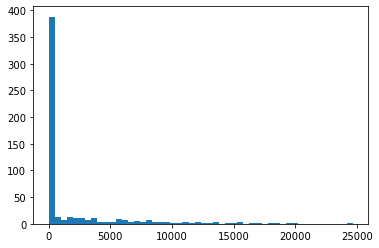

In [4]:
plt.hist(population[12], bins=50)
plt.show()

In [7]:
pkl_file = open("Data/Yerevan_OD_matrices.pkl", "rb")
OD_matrices = pickle.load(pkl_file)
pkl_file.close()
print(OD_matrices)

[[[ 42.   0.   0. ...   0.   0.   0.]
  [  0.  42.   0. ...   0.   0.   0.]
  [  0.   0.  42. ...   0.   0.   0.]
  ...
  [  0.   0.   0. ... 853.   0.   0.]
  [  0.   0.   0. ...   0.  42.   0.]
  [  0.   0.   0. ...   0.   0.  42.]]

 [[ 76.   0.   0. ...   0.   0.   0.]
  [  0.  76.   0. ...   0.   0.   0.]
  [  0.   0.  76. ...   0.   0.   0.]
  ...
  [  0.   0.   0. ... 765.   0.   0.]
  [  0.   0.   0. ...   0.  76.   0.]
  [  0.   0.   0. ...   0.   0.  76.]]

 [[ 63.   0.   0. ...   0.   0.   0.]
  [  0.  63.   0. ...   0.   0.   0.]
  [  0.   0.  63. ...   0.   0.   0.]
  ...
  [  0.   0.   0. ... 765.   0.   0.]
  [  0.   0.   0. ...   0.  63.   0.]
  [  0.   0.   0. ...   0.   0.  63.]]

 ...

 [[ 17.   0.   0. ...   0.   0.   0.]
  [  0.  17.   0. ...   0.   0.   0.]
  [  0.   0.  17. ...   0.   0.   0.]
  ...
  [  0.   0.   0. ... 444.   0.   0.]
  [  0.   0.   0. ...   0.  17.   0.]
  [  0.   0.   0. ...   0.   0.  17.]]

 [[ 20.   0.   0. ...   0.   0.   0.]
  [  0.  20.

In [ ]:
OD_matrices.shape

In [ ]:
plt.imshow(OD_matrices[12], cmap='Blues')
plt.show()

In [ ]:
print("On-diagonal sum: ", np.diagonal(OD_matrices[12]).sum())
print("Off-diagonal sum: ", OD_matrices[12].sum() - np.diagonal(OD_matrices[12]).sum())

## Covid-19 model

In [ ]:
from collections import namedtuple

In [ ]:
Param = namedtuple('Param', 'R0 DE DI I0 HospitalisationRate HospiterIters')
# I0 is the distribution of infected people at time t=0, if None then randomly choose inf number of people

In [ ]:
# flow is a 3D matrix of dimensions r x n x n (i.e., 84 x 549 x 549),
# flow[t mod r] is the desired OD matrix at time t.

def seir(par, distr, flow, alpha, iterations, inf):
    
    r = flow.shape[0]
    n = flow.shape[1]
    N = distr[0].sum() # total population, we assume that N = sum(flow)
    
    Svec = distr[0].copy()
    Evec = np.zeros(n)
    Ivec = np.zeros(n)
    Rvec = np.zeros(n)
    
    if par.I0 is None:
        initial = np.zeros(n)
        # randomly choose inf infections
        for i in range(inf):
            loc = np.random.randint(n)
            if (Svec[loc] > initial[loc]):
                initial[loc] += 1.0
                
    else:
        initial = par.I0
    assert ((Svec < initial).sum() == 0)
    
    Svec =- initial
    Ivec =+ initial
    
    res = np.zeros((iterations, 5))
    res[0,:] = [Svec.sum(), Evec.sum(), Ivec.sum(), Rvec.sum(), 0]
    
    realflow = flow.copy() # copy!
    
#     for j in range(r):
#         for i in range(n):
#             realflow[j][i] /= realflow[j][i].sum()

    # The two lines below normalise the flows and then multiply them by the alpha values. 
    # This is actually the "wrong" the way to do it because alpha will not be a *linear* measure 
    # representing lockdown strength but a *nonlinear* one.
    # The normalisation strategy has been chosen for demonstration purposes of numpy functionality.
    # (Optional) can you rewrite this part so that alpha remains a linear measure of lockdown strength? :)
    realflow = realflow / realflow.sum(axis=2)[:,:, np.newaxis]    
    realflow = alpha * realflow    
    
    history = np.zeros((iterations, 5, n))
    history[0,0,:] = Svec
    history[0,1,:] = Evec
    history[0,2,:] = Ivec
    history[0,3,:] = Rvec
    
    eachIter = np.zeros(iterations + 1)
    
    # run simulation
    for iter in range(0, iterations - 1):
        realOD = realflow[iter % r]
        
        d = distr[iter % r] + 1
        
        if ((d>N+1).any()): #assertion!
            print("Houston, we have a problem!")
            return res, history
        # N =  S + E + I + R
        
        newE = Svec * Ivec / d * par.R0 / par.DI
        newI = Evec / par.DE
        newR = Ivec / par.DI
        
        Svec -= newE
        Svec = (Svec 
               + np.matmul(Svec.reshape(1,n), realOD)
               - Svec * realOD.sum(axis=1)
                )
        Evec = Evec + newE - newI
        Evec = (Evec 
               + np.matmul(Evec.reshape(1,n), realOD)
               - Evec * realOD.sum(axis=1)
                )
                
        Ivec = Ivec + newI - newR
        Ivec = (Ivec 
               + np.matmul(Ivec.reshape(1,n), realOD)
               - Ivec * realOD.sum(axis=1)
                )
                
        Rvec += newR
        Rvec = (Rvec 
               + np.matmul(Rvec.reshape(1,n), realOD)
               - Rvec * realOD.sum(axis=1)
                )
                
        res[iter + 1,:] = [Svec.sum(), Evec.sum(), Ivec.sum(), Rvec.sum(), 0]
        eachIter[iter + 1] = newI.sum()
        res[iter + 1, 4] = eachIter[max(0, iter - par.HospiterIters) : iter].sum() * par.HospitalisationRate
        
        history[iter + 1,0,:] = Svec
        history[iter + 1,1,:] = Evec
        history[iter + 1,2,:] = Ivec
        history[iter + 1,3,:] = Rvec
        
        
    return res, history